In [1]:
import sys
print(sys.executable)          # should show /Users/newspeed/.venvs/ds/bin/python
!{sys.executable} -m pip -V    # confirms pip targets the venv

/Users/newspeed/.venvs/ds/bin/python3
pip 25.3 from /Users/newspeed/.venvs/ds/lib/python3.12/site-packages/pip (python 3.12)


In [3]:
# QUICK DATASET SMOKE TEST

import os, glob, sys
import pandas as pd

# 1) Find data files (looks under ./data first, then anywhere under cwd)
candidates = []
for pattern in [
    "data/**/*.csv", "data/**/*.parquet",
    "**/*.csv", "**/*.parquet",
]:
    candidates += glob.glob(pattern, recursive=True)

# De-dupe and keep readable paths
candidates = sorted(set(candidates))
print(f"Found {len(candidates)} data file(s).")
for i, p in enumerate(candidates[:10], 1):
    print(f"{i:>2}. {p}")

assert candidates, "No CSV/Parquet files found. Did you unzip the dataset?"

# 2) Pick the first CSV, else first Parquet
csvs   = [p for p in candidates if p.lower().endswith(".csv")]
parqs  = [p for p in candidates if p.lower().endswith(".parquet")]
path   = (csvs or parqs)[0]
print("\nLoading:", path)

# 3) Load
if path.lower().endswith(".csv"):
    df = pd.read_csv(path, nrows=50_000)   # cap rows for quick test
else:
    try:
        df = pd.read_parquet(path)
    except Exception as e:
        raise SystemExit(
            f"Reading Parquet failed ({e}). "
            "Install a reader with:  pip install pyarrow  or  pip install fastparquet"
        )

# 4) Basic checks
print("\nShape:", df.shape)
print("Columns:", list(df.columns)[:20], "..." if len(df.columns) > 20 else "")
print("\nNulls (top 10 cols):")
print(df.isna().sum().sort_values(ascending=False).head(10))

display(df.head())

# 5) Light profiling
print("\nSample stats (numeric columns):")
display(df.select_dtypes("number").describe().T.head(10))

print("\nValue counts preview (first non-numeric column):")
non_num = [c for c in df.columns if df[c].dtype == "object"]
if non_num:
    display(df[non_num[0]].value_counts().head(10))
else:
    print("(no object/categorical columns found)")


Found 5 data file(s).
 1. data/pqc/kem_benchmark_results.csv
 2. data/pqc/signature_benchmark_results.csv
 3. pqc_perf_data.csv
 4. pqc_perf_data_test.csv
 5. pqc_perf_schema.csv

Loading: data/pqc/kem_benchmark_results.csv

Shape: (37004, 16)
Columns: ['algorithm', 'keygen_time_ms', 'encap_time_ms', 'decap_time_ms', 'ciphertext_length', 'shared_secret_length', 'overhead_bytes', 'total_time_ms', 'correctness', 'type', 'text_size_kb', 'text_length_bytes', 'run_id', 'timestamp', 'security_level_bits', 'security_level'] 

Nulls (top 10 cols):
algorithm               0
keygen_time_ms          0
encap_time_ms           0
decap_time_ms           0
ciphertext_length       0
shared_secret_length    0
overhead_bytes          0
total_time_ms           0
correctness             0
type                    0
dtype: int64


,algorithm,keygen_time_ms,encap_time_ms,decap_time_ms,ciphertext_length,shared_secret_length,overhead_bytes,total_time_ms,correctness,type,text_size_kb,text_length_bytes,run_id,timestamp,security_level_bits,security_level
0,BIKE-L1,8.220911,0.476837,6.126165,1573,32,1541,14.823914,True,KEM,0.5,512,1,2025-04-07T09:04:19.790636,128,1
1,BIKE-L3,21.829844,1.256943,16.112328,3115,32,3083,39.199114,True,KEM,0.5,512,1,2025-04-07T09:04:19.829883,192,2
2,BIKE-L5,46.767712,2.524376,37.101746,5154,32,5122,86.393833,True,KEM,0.5,512,1,2025-04-07T09:04:19.916316,256,3
3,Classic-McEliece-348864,93.240976,0.107050,17.526865,96,32,64,110.874891,True,KEM,0.5,512,1,2025-04-07T09:04:20.027250,128,1
4,Classic-McEliece-348864f,29.181004,0.037670,16.361237,96,32,64,45.579910,True,KEM,0.5,512,1,2025-04-07T09:04:20.072888,128,1



Sample stats (numeric columns):


,count,mean,std,min,25%,50%,75%,max
keygen_time_ms,37004.0,71.456538,1283.209902,0.009775,0.416994,2.707243,85.134983,245504.775763
encap_time_ms,37004.0,0.924705,1.429549,0.009775,0.041246,0.184774,1.038074,9.560108
decap_time_ms,37004.0,20.280116,26.511202,0.006676,0.315189,4.781008,33.585608,244.152069
ciphertext_length,37004.0,4878.517241,6662.425115,96.000000,208.000000,1088.000000,8978.000000,21632.000000
shared_secret_length,37004.0,33.655172,11.192131,16.000000,32.000000,32.000000,32.000000,64.000000
overhead_bytes,37004.0,4844.862069,6661.950499,64.000000,176.000000,1056.000000,8914.000000,21600.000000
total_time_ms,37004.0,92.661359,1286.541919,0.027895,1.753092,11.262178,118.201017,245749.175072
text_size_kb,37004.0,64.250000,36.835434,0.500000,32.375000,64.250000,96.125000,128.000000
text_length_bytes,37004.0,65791.600313,37719.483995,512.000000,33151.500000,65791.500000,98431.500000,131072.000000
run_id,37004.0,638.500000,368.354336,1.000000,319.750000,638.500000,957.250000,1276.000000



Value counts preview (first non-numeric column):


algorithm
BIKE-L1                      1276
BIKE-L3                      1276
BIKE-L5                      1276
Classic-McEliece-348864      1276
Classic-McEliece-348864f     1276
Classic-McEliece-460896      1276
Classic-McEliece-460896f     1276
Classic-McEliece-6688128     1276
Classic-McEliece-6688128f    1276
Classic-McEliece-6960119     1276
Name: count, dtype: int64

# Project 3 — PQC Performance Modeling

_Full starter notebook with Preprocessing → Modeling → Visualization_

*Generated: 2025-09-26 22:00:48*

## 1) Preprocessing
This section loads your CSV, cleans data, and engineers features ready for ML.

In [2]:

# 1.1 Configuration
CSV_PATH = "pqc_perf_data.csv"   # <-- change to your file path if needed
TARGET = "latency_ms"            # or "throughput_ops" if you prefer
RANDOM_SEED = 42
PRINT_ROWS = 5

import os, sys, platform, numpy as np, pandas as pd
np.set_printoptions(edgeitems=5, linewidth=120)
pd.set_option("display.max_columns", 100)

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("CSV_PATH:", CSV_PATH)


Python: 3.12.11
Platform: macOS-15.4.1-x86_64-i386-64bit
CSV_PATH: pqc_perf_data.csv


In [2]:

# 1.2 Load data
import pandas as pd

try:
    df = pd.read_csv(CSV_PATH)
    print("Loaded rows:", len(df))
    display(df.head(PRINT_ROWS))
except FileNotFoundError:
    raise SystemExit(f"CSV not found at {CSV_PATH}. Generate it with pqc_benchmark_harness.py.")


Loaded rows: 7416


,alg_family,param_set,operation,message_bytes,concurrency,cpu_ghz,aesni,avx2,neon,machine_id,os_name,containerized,latency_ms,throughput_ops,timestamp,notes,trial_id
0,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.0694,80.48,2025-08-19T01:07:51.325598,NaN,1
1,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,11.7811,82.23,2025-08-19T01:07:51.325967,NaN,2
2,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.6677,77.31,2025-08-19T01:07:51.325979,NaN,3
3,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.3687,82.42,2025-08-19T01:07:51.325987,NaN,4
4,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,11.4171,85.70,2025-08-19T01:07:51.326015,NaN,5


In [3]:

# 1.3 Quick schema sanity & basic cleaning
expected_cols = [
    "alg_family","param_set","operation","message_bytes","concurrency",
    "cpu_ghz","aesni","avx2","neon","machine_id","os_name","containerized",
    "latency_ms","throughput_ops","timestamp","notes","trial_id"
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("Warning: missing expected columns:", missing)

# Drop duplicates; filter impossible values
df = df.drop_duplicates()
if "latency_ms" in df.columns:
    df = df[df["latency_ms"].notna() & (df["latency_ms"] >= 0)]
if "throughput_ops" in df.columns:
    df = df[df["throughput_ops"].notna() & (df["throughput_ops"] >= 0)]

print("After basic cleaning:", df.shape)
display(df.head(PRINT_ROWS))


After basic cleaning: (7416, 17)


,alg_family,param_set,operation,message_bytes,concurrency,cpu_ghz,aesni,avx2,neon,machine_id,os_name,containerized,latency_ms,throughput_ops,timestamp,notes,trial_id
0,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.0694,80.48,2025-08-19T01:07:51.325598,NaN,1
1,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,11.7811,82.23,2025-08-19T01:07:51.325967,NaN,2
2,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.6677,77.31,2025-08-19T01:07:51.325979,NaN,3
3,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,12.3687,82.42,2025-08-19T01:07:51.325987,NaN,4
4,ML-KEM,512,keygen,0,1,0.0,0,0,0,MacBook-Pro-4.local,darwin,0,11.4171,85.70,2025-08-19T01:07:51.326015,NaN,5


In [4]:

# 1.4 Feature engineering
import numpy as np

# Composite algorithm identifier
if set(["alg_family","param_set","operation"]).issubset(df.columns):
    df["alg_param"] = df["alg_family"].astype(str) + "_" + df["param_set"].astype(str) + "_" + df["operation"].astype(str)

# Ensure types
for col in ["message_bytes","concurrency","cpu_ghz","aesni","avx2","neon","containerized"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Log-transform latency for modeling stability (kept as an extra feature)
if "latency_ms" in df.columns:
    df["log_latency"] = np.log1p(df["latency_ms"])

# Keep a clean feature list (drop targets, ids, free-text)
drop_cols = {TARGET, "log_latency", "timestamp", "notes", "trial_id"}
features = [c for c in df.columns if c not in drop_cols]
print("Candidate features:", features)


Candidate features: ['alg_family', 'param_set', 'operation', 'message_bytes', 'concurrency', 'cpu_ghz', 'aesni', 'avx2', 'neon', 'machine_id', 'os_name', 'containerized', 'throughput_ops', 'alg_param']


In [5]:

# 1.5 Train/test split
from sklearn.model_selection import train_test_split

y = df[TARGET].copy()
X = df[features].copy()

# Example group-wise split: hold out one machine to test generalization across hardware
group_col = "machine_id" if "machine_id" in X.columns else None
if group_col and X[group_col].nunique() > 1:
    held_out = X[group_col].unique()[-1]
    train_idx = X[group_col] != held_out
    test_idx  = X[group_col] == held_out
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print(f"Held-out machine: {held_out} | train={X_train.shape} test={X_test.shape}")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Random split:", X_train.shape, X_test.shape)


Random split: (5932, 14) (1484, 14)


## 2) Modeling
We train a baseline linear model, a flexible tree-based model, and quantile regressors for p95/p99.

In [19]:

# 2.1 Baseline: Regularized Linear (Ridge)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

ridge = Pipeline([("pre", pre), ("model", Ridge(alpha=1.0, random_state=42))])
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
mae = mean_absolute_error(y_test, pred_ridge)
mse = mean_squared_error(y_test, pred_ridge)
rmse = np.sqrt(mse) # Use numpy.sqrt to get the square root
print(f"Ridge → MAE={mae:.4f} | RMSE={rmse:.4f}")


Ridge → MAE=1.5893 | RMSE=2.1304


In [22]:

# 2.2 Flexible model: RandomForest (uses minimal preprocessing)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]
pre2 = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)], remainder="passthrough")

rf = Pipeline([
    ("pre", pre2),
    ("rf", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = np.sqrt(mse_rf) # Use numpy.sqrt to get the square root
print(f"RandomForest → MAE={mae_rf:.4f} | RMSE={rmse_rf:.4f}")


RandomForest → MAE=0.3082 | RMSE=0.4525


In [23]:

# 2.3 Optional: XGBoost if installed
try:
    import xgboost as xgb
    use_xgb = True
except Exception:
    use_xgb = False
    print("xgboost not installed; skipping XGB model.")

if use_xgb:
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_train.columns if c not in num_cols]
    pre3 = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)], remainder="passthrough")

    xgb_model = xgb.XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_pipe = Pipeline([("pre", pre3), ("xgb", xgb_model)])
    xgb_pipe.fit(X_train, y_train)
    pred_xgb = xgb_pipe.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, pred_xgb)
    mse_xgb = mean_squared_error(y_test, pred_xgb)
    rmse_xgb = np.sqrt(rmse_xgb) # Use numpy.sqrt to get the square root
    print(f"XGBoost → MAE={mae_xgb:.4f} | RMSE={rmse_xgb:.4f}")


XGBoost → MAE=0.2725 | RMSE=1.4596


In [10]:

# 2.4 Quantile regression (p50/p95/p99) with GradientBoostingRegressor
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

quantiles = (0.5, 0.95, 0.99)
qr_models = {}
X_train_dm = pd.get_dummies(X_train)
X_test_dm  = pd.get_dummies(X_test).reindex(columns=X_train_dm.columns, fill_value=0)
for q in quantiles:
    m = GradientBoostingRegressor(loss="quantile", alpha=q, random_state=42)
    m.fit(X_train_dm, y_train)
    qr_models[q] = m

q = 0.95
q_pred = qr_models[q].predict(X_test_dm)
emp_cov = float((y_test <= q_pred).mean())
print(f"Quantile {q:.2f} empirical coverage: {emp_cov:.3f}")


Quantile 0.95 empirical coverage: 0.947


## 3) Visualization
Simple plots to understand distributions, compare algorithms, and inspect model behavior.

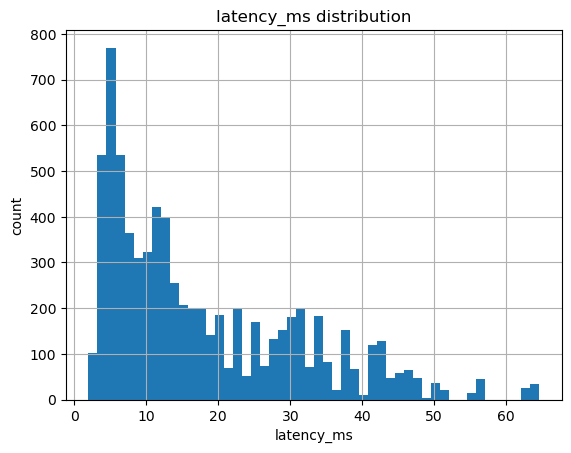

In [11]:

import matplotlib.pyplot as plt

# 3.1 Latency/Throughput histogram
plt.figure()
df[TARGET].hist(bins=50)
plt.title(f"{TARGET} distribution")
plt.xlabel(TARGET); plt.ylabel("count")
plt.show()


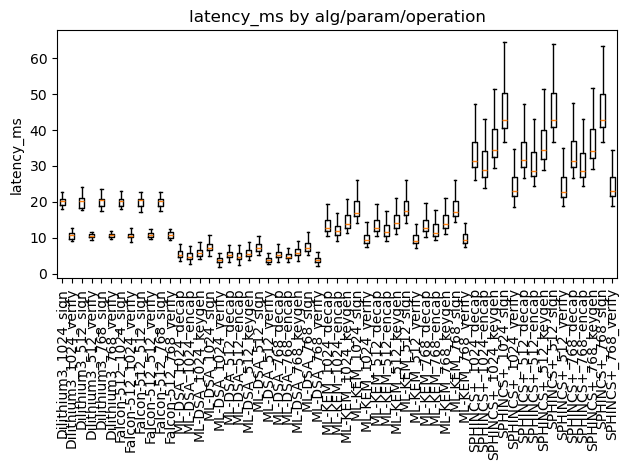

In [13]:

# 3.2 Boxplot by alg/param/operation (using 'alg_param' if present)
if "alg_param" in df.columns and TARGET in df.columns:
    plt.figure()
    groups = df.groupby("alg_param")[TARGET]
    data = [g.values for _, g in groups]
    labels = [k for k, _ in groups]
    plt.boxplot(data, tick_labels=labels, vert=True, showfliers=False)
    plt.title(f"{TARGET} by alg/param/operation")
    plt.xticks(rotation=90)
    plt.ylabel(TARGET)
    plt.tight_layout()
    plt.show()


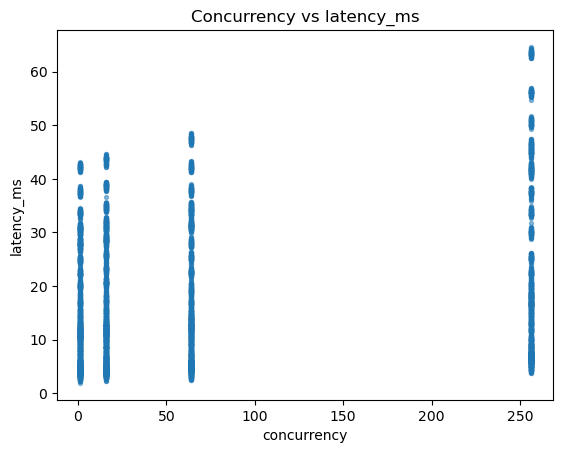

In [14]:

# 3.3 Scatter: concurrency vs target
if "concurrency" in df.columns and TARGET in df.columns:
    plt.figure()
    plt.scatter(df["concurrency"], df[TARGET], s=8, alpha=0.5)
    plt.title(f"Concurrency vs {TARGET}")
    plt.xlabel("concurrency"); plt.ylabel(TARGET)
    plt.show()


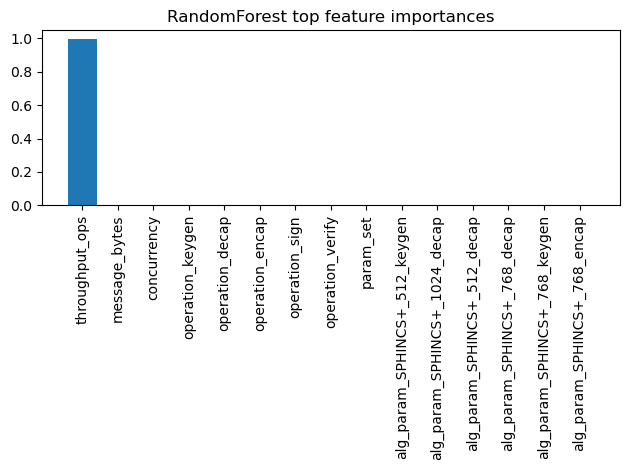

In [15]:

# 3.4 Feature importance from RandomForest
try:
    pre = rf.named_steps["pre"]
    cat_features = pre.transformers_[0][2]
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np

    ohe = pre.transformers_[0][1]
    ohe_cols = ohe.get_feature_names_out(cat_features)
    num_cols = [c for c in X_train.columns if c not in cat_features]
    colnames = list(ohe_cols) + num_cols

    importances = rf.named_steps["rf"].feature_importances_
    order = np.argsort(importances)[::-1][:15]

    plt.figure()
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), [colnames[i] for i in order], rotation=90)
    plt.title("RandomForest top feature importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)


In [16]:

# 3.5 What-if helper using your best model (rf/xgb/ridge)
best_model = rf  # change if another model performs better

def predict_target(example: dict, model, columns):
    import pandas as pd
    X_ex = pd.DataFrame([example], columns=columns)
    return float(model.predict(X_ex)[0])

example = {
    "alg_family": "Dilithium3",
    "param_set": "",
    "operation": "sign",
    "message_bytes": 1024,
    "concurrency": 64,
    "cpu_ghz": 0.0,
    "aesni": 0, "avx2": 0, "neon": 0,
    "machine_id": X_train["machine_id"].iloc[0] if "machine_id" in X_train.columns else "",
    "os_name": X_train["os_name"].iloc[0] if "os_name" in X_train.columns else "",
    "containerized": 0,
    "alg_param": "Dilithium3__sign"
}
try:
    print("What-if predicted", TARGET, "=", predict_target(example, best_model, X_train.columns))
except Exception as e:
    print("What-if example failed (adjust keys to match your columns):", e)


What-if example failed (adjust keys to match your columns): For a sparse output, all columns should be a numeric or convertible to a numeric.


---
**Tip:** To predict throughput instead, set `TARGET = 'throughput_ops'` above and rerun all.